In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
import query_db
import composite
import spectral_analysis as sa
import scipy.interpolate as inter
from scipy.special import erf

In [3]:
epoch_n_91t, wavelength_nugent_91t, flux_nugent_91t = np.loadtxt('../data/info_files/nugent_91t_templates.dat', unpack = True)
epoch_n_91bg, wavelength_nugent_91bg, flux_nugent_91bg = np.loadtxt('../data/info_files/nugent_91bg_templates.dat', unpack = True)

In [4]:
phase_s, wavelength_salt, flux_salt = np.loadtxt('../data/info_files/SALT/salt2-4/salt2_template_0.dat', unpack = True)
phase_s_corr, wavelength_salt_corr, salt_corr = np.loadtxt('../data/info_files/SALT/salt2-4/salt2_template_1.dat', unpack = True)
flux_salt_m2 = flux_salt - 3.06*salt_corr #dm15=1.61
flux_salt_p1 = flux_salt + 1.85*salt_corr #dm15=.84
# flux_salt_m2 = flux_salt - 2.68*salt_corr #using fit from guy07
# flux_salt_p1 = flux_salt + 1.76*salt_corr #using fit from guy07

In [5]:
salt_temps_m2 = {}
phase_list = []
first = True
for i, phase in enumerate(phase_s):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            salt_temps_m2[float(phase_s[i-1])] = [temp_wave, temp_flux]
        temp_wave = [wavelength_salt[i]]
        temp_flux = [flux_salt_m2[i]]
    else:
        temp_wave.append(wavelength_salt[i])
        temp_flux.append(flux_salt_m2[i])
    first = False
    
salt_temps_p1 = {}
phase_list = []
first = True
for i, phase in enumerate(phase_s):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            salt_temps_p1[float(phase_s[i-1])] = [temp_wave, temp_flux]
        temp_wave = [wavelength_salt[i]]
        temp_flux = [flux_salt_p1[i]]
    else:
        temp_wave.append(wavelength_salt[i])
        temp_flux.append(flux_salt_p1[i])
    first = False

In [6]:
nug_temps_91t = {}
phase_list = []
first = True
for i, phase in enumerate(epoch_n_91t):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            nug_temps_91t[float(epoch_n_91t[i-1]) - 20.] = [temp_wave, temp_flux]
        temp_wave = [wavelength_nugent_91t[i]]
        temp_flux = [flux_nugent_91t[i]]
    else:
        temp_wave.append(wavelength_nugent_91t[i])
        temp_flux.append(flux_nugent_91t[i])
    first = False
    
nug_temps_91bg = {}
phase_list = []
first = True
for i, phase in enumerate(epoch_n_91bg):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            nug_temps_91bg[float(epoch_n_91bg[i-1]) - 20.] = [temp_wave, temp_flux]
        temp_wave = [wavelength_nugent_91bg[i]]
        temp_flux = [flux_nugent_91bg[i]]
    else:
        temp_wave.append(wavelength_nugent_91bg[i])
        temp_flux.append(flux_nugent_91bg[i])
    first = False

In [7]:
def make_obj_from_template(wave, flux):
    wave_s = wave
    flux_s = flux
    wave_interp_s = np.arange(1000., 12000., dtype=int, step=2)
    flux_spl_s = inter.splrep(wave_s, flux_s)
    flux_interp_s = inter.splev(wave_interp_s, flux_spl_s, ext = 3)
    s_template = composite.supernova(wave_interp_s, flux_interp_s)
    s_template.phase_array = np.zeros(len(flux_interp_s))
    return s_template

In [8]:
m2_salt_template = make_obj_from_template(salt_temps_m2[0.][0], salt_temps_m2[0.][1])
p1_salt_template = make_obj_from_template(salt_temps_p1[0.][0], salt_temps_p1[0.][1])
nug91t_template = make_obj_from_template(nug_temps_91t[0.][0], nug_temps_91t[0.][1])
nug91bg_template = make_obj_from_template(nug_temps_91bg[0.][0], nug_temps_91bg[0.][1])

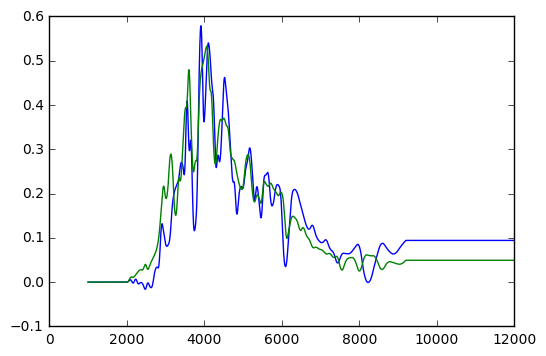

In [9]:
plt.plot(m2_salt_template.wavelength, m2_salt_template.flux)
plt.plot(p1_salt_template.wavelength, p1_salt_template.flux)
plt.show()

In [10]:
query = ["SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -1 and phase <= 1 and ((dm15_source <= .9) or (dm15_from_fits <= .9)) and Supernovae.SN !='2002bf'"]

In [11]:
composites_p1, sn_arrays_p1, boot_sn_arrays_p1 = query_db.main(len(query), query, boot='b', medmean=1, gini_balance=True, verbose=False)

SQL Query: SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -1 and phase <= 1 and ((dm15_source <= .9) or (dm15_from_fits <= .9)) and Supernovae.SN !='2002bf'
172 questionable files currently ignored
0 questionable spectra removed 23 spectra left
0 Peculiar Ias removed 23 spectra left
23 spectra with host corrections
172 questionable files currently ignored
15 valid SNe found
Arrays cleaned
15 spectra may have telluric contamination
15 SNs with host corrections
Creating composite...
Gini balancing...


C:\Program Files\Anaconda2\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Balanced after 4 iterations
Done.
Bootstrapping
scaling boots...
computing confidence intervals...
v =  10509.0501147
v_err =  825.775897871


In [12]:
query_db.set_min_num_spec(composites_p1, 5)

In [13]:
composites_p1[0].name = "Comp"
p1_salt_template.name = "SALT-II"
comps_and_temps = []
for comp in composites_p1:
    comps_and_temps.append(comp)
comps_and_temps.append(p1_salt_template)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[1], True)

0.851307323133


query_db.py:658: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  comp.low_conf = norm*comp.low_conf
query_db.py:659: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  comp.up_conf = norm*comp.up_conf


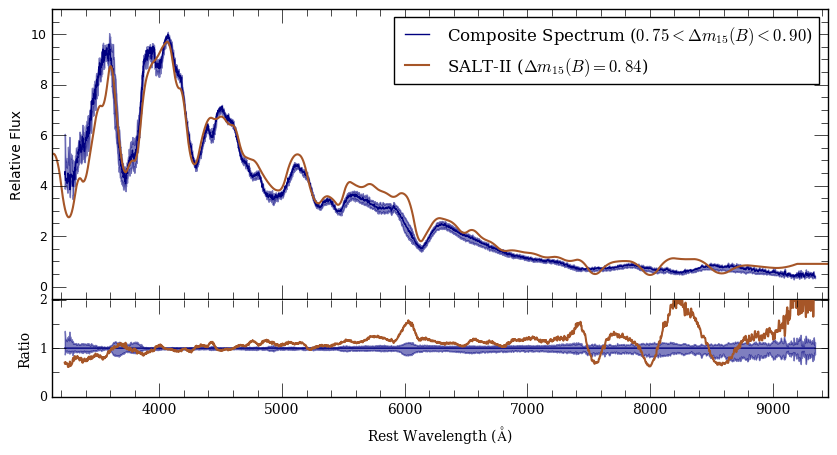

In [14]:
print np.average(comps_and_temps[0].dm15_array[comps_and_temps[0].x1:comps_and_temps[0].x2])
query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1]], legend_labels = ["Composite Spectrum ($ 0.75 < \Delta m_{15} (B) < 0.90$)", "SALT-II ($\Delta m_{15} (B) = 0.84$)"])

In [15]:
query = ["SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.5 and dm15_source < 1.7) or (dm15_from_fits >= 1.5 and dm15_from_fits < 1.7)) and Supernovae.SN !='2002bf'"]

In [16]:
composites_m2, sn_arrays_m2, boot_sn_arrays_m2 = query_db.main(len(query), query, boot='b', medmean=1, gini_balance=True, verbose=False)

SQL Query: SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.5 and dm15_source < 1.7) or (dm15_from_fits >= 1.5 and dm15_from_fits < 1.7)) and Supernovae.SN !='2002bf'
172 questionable files currently ignored
4 questionable spectra removed 47 spectra left
5 Peculiar Ias removed 42 spectra left
40 spectra with host corrections
172 questionable files currently ignored
13 valid SNe found
Arrays cleaned
13 spectra may have telluric contamination
13 SNs with host corrections
Creating composite...
Gini balancing...
Balanced after 5 iterations
Done.
Bootstrapping
scaling boots...
computing confidence intervals...
v =  11290.7621201
v_err =  339.063321599


In [17]:
query_db.set_min_num_spec(composites_m2, 1)

In [18]:
composites_m2[0].name = "Comp"
m2_salt_template.name = "SALT-II"
comps_and_temps = []
for comp in composites_m2:
    comps_and_temps.append(comp)
comps_and_temps.append(m2_salt_template)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[1], True)

1.62152794434


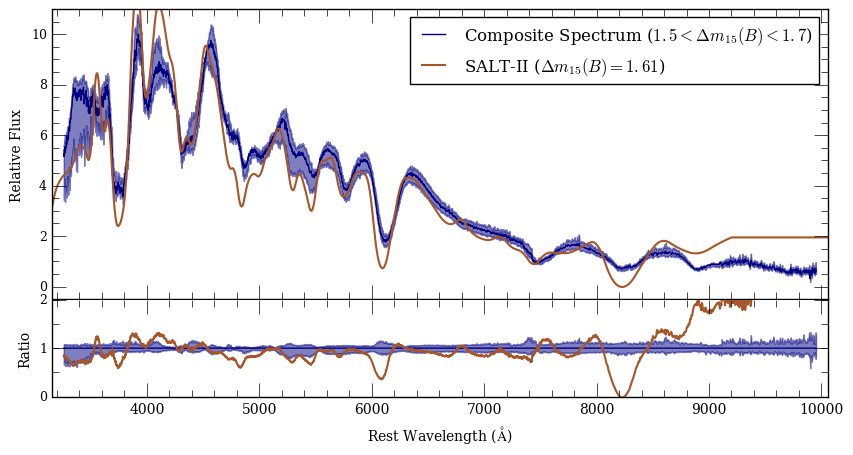

In [19]:
print np.average(comps_and_temps[0].dm15_array[comps_and_temps[0].x1:comps_and_temps[0].x2])
query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1]], 
                     legend_labels = ["Composite Spectrum ($ 1.5 < \Delta m_{15} (B) < 1.7$)", "SALT-II ($\Delta m_{15} (B) = 1.61$)"])

## Warp Hsiao Templates

In [20]:
phase_h, wavelength_hsiao, flux_hsiao = np.loadtxt('../data/info_files/hsiao_template.dat', unpack = True)

In [21]:
hsiao_temps = {}
phase_list = []
first = True
for i, phase in enumerate(phase_h):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            hsiao_temps[float(phase_h[i-1])] = [temp_wave, temp_flux]
        temp_wave = [wavelength_hsiao[i]]
        temp_flux = [flux_hsiao[i]]
    else:
        temp_wave.append(wavelength_hsiao[i])
        temp_flux.append(flux_hsiao[i])
    first = False

In [22]:
import pyphot
import scipy.interpolate as inter
import scipy.optimize as opt

In [23]:
def color_residuals(spline_knot_vals, true_BmV, true_VmR, spectrum, Beff = 4315.522317, Veff = 5438.689405, Reff = 6389.952199):
    print spline_knot_vals
    spline_knot_locs = [Beff, Veff, Reff]
    spline = inter.splrep(spline_knot_locs, spline_knot_vals, k=2)
    spline_func = inter.splev(hsiao_max[0], spline, ext = 0)
    warped_flux = spline_func*spectrum[1]

    Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_flux), axis = -1)
    Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag

    Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_flux), axis = -1)
    Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

    Rflux = R.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_flux), axis = -1)
    Rmag = -2.5 * np.log10(Rflux) - R.Vega_zero_mag
    
    new_BmV = Bmag - Vmag
    new_VmR = Vmag - Rmag
    print new_BmV, new_VmR
    return (new_BmV - true_BmV)**2. + (new_VmR - true_VmR)**2.
#     return (new_BmV - true_BmV)**2.

In [24]:
lib = pyphot.get_library()
f = lib.find('Johnson')
# for name in f:
#     lib[name].info(show_zeropoints=True)
U = lib['GROUND_JOHNSON_U']
B = lib['GROUND_JOHNSON_B']
V = lib['GROUND_JOHNSON_V']
R = lib['GROUND_COUSINS_R']

In [25]:
phase = 0.
hsiao_max = hsiao_temps[phase]
# Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
# Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
# Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag
# Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

In [26]:
# Ueff = 3709.279027
Beff = 4315.522317
Veff = 5438.689405
Reff = 6389.952199
spline_knot_locs = [Beff, Veff, Reff]
spline_knot_vals = [1.00000001, 1.0, 1.0]
spline = inter.splrep(spline_knot_locs, spline_knot_vals, k=2)
spline_func = inter.splev(hsiao_max[0], spline, ext = 0)

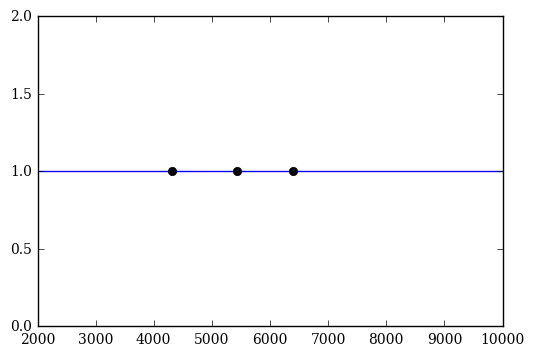

In [27]:
plt.plot(hsiao_max[0], spline_func)
plt.plot(spline_knot_locs, spline_knot_vals, 'ko')
plt.xlim([2000,10000])
plt.ylim([0,2])
plt.show()

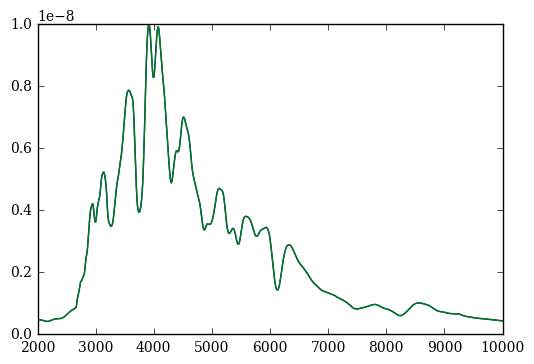

In [28]:
warped_hsiao = spline_func*hsiao_max[1]
plt.plot(hsiao_max[0], hsiao_max[1])
plt.plot(hsiao_max[0], warped_hsiao)
plt.xlim([2000,10000])
plt.show()

In [29]:
Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag

Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

Rflux = R.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
Rmag = -2.5 * np.log10(Rflux) - R.Vega_zero_mag

print Bmag, Vmag, Rmag
print Bmag - Vmag, Vmag - Rmag

Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_hsiao), axis = -1)
Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag

Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_hsiao), axis = -1)
Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

Rflux = R.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_hsiao), axis = -1)
Rmag = -2.5 * np.log10(Rflux) - R.Vega_zero_mag

print Bmag - Vmag, Vmag - Rmag

-0.0371200866077 0.0423958457655 0.0355232036651
-0.0795159323732 0.00687264210036
-0.079515943888 0.00687264266107


In [30]:
comp = composites_p1[0]

true_Bflux = B.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Bmag = -2.5 * np.log10(true_Bflux) - B.Vega_zero_mag

true_Vflux = V.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Vmag = -2.5 * np.log10(true_Vflux) - V.Vega_zero_mag

true_Rflux = R.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Rmag = -2.5 * np.log10(true_Rflux) - R.Vega_zero_mag

In [31]:
print true_Bmag, true_Vmag, true_Rmag

-22.5507559878 -22.4326120305 -22.3436809969


In [32]:
true_BmV = true_Bmag - true_Vmag
true_VmR = true_Vmag - true_Rmag
print true_BmV, true_VmR

-0.118143957337 -0.0889310335723


In [33]:
best_knots = opt.minimize(color_residuals, spline_knot_vals, args = (true_BmV, true_VmR, hsiao_max), method = 'Nelder-Mead').x
print best_knots

[ 1.00000001  1.          1.        ]
-0.079515943888 0.00687264266107
[ 1.05000001  1.          1.        ]
-0.135497477458 0.00966655441418
[ 1.00000001  1.05        1.        ]
-0.0221791626868 -0.0479932773108
[ 1.00000001  1.          1.05      ]
-0.0802701495813 0.0585216073775
[ 1.03333334  1.03333333  0.95      ]
-0.0782875049926 -0.0828109201571
[ 1.05000001  1.05        0.9       ]
-0.0773296001607 -0.158197606426
[ 1.05555557  0.97222222  0.96666667]
-0.173604599397 0.00561625451201
[ 1.0138889   1.03055556  0.99166667]
-0.0600866037679 -0.0350243565209
[ 1.06481483  1.04259259  0.96111111]
-0.102728830612 -0.0785269106788
[ 1.09722223  1.06388889  0.94166667]
-0.113538572985 -0.121389259373
[ 1.02469137  1.07098765  0.93518519]
-0.0259737388164 -0.141269274936
[ 1.04367285  1.01774691  0.9837963 ]
-0.108000233839 -0.027694515666
[ 1.08065845  1.031893    0.9382716 ]
-0.13151350443 -0.0915010295864
[ 1.11404322  1.03256173  0.91157407]
-0.165516898827 -0.1208611721
[ 1.07553

In [34]:
best_spline = inter.splrep(spline_knot_locs, best_knots, k=2)
best_spline_func = inter.splev(hsiao_max[0], best_spline, ext = 0)

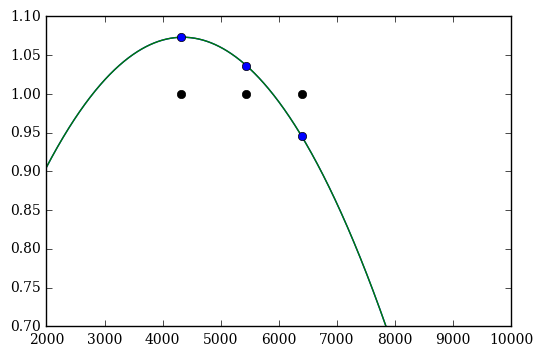

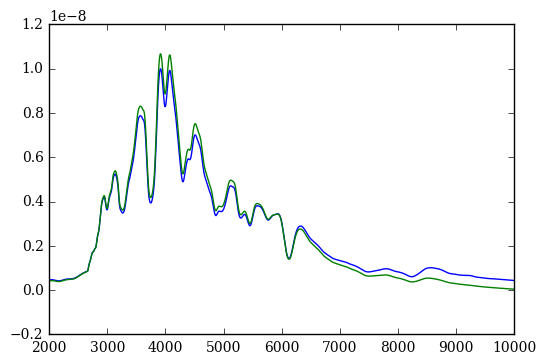

In [35]:
warped_hsiao = best_spline_func*hsiao_max[1]
# plt.plot(hsiao_max[0], hsiao_max[1])
# plt.plot(hsiao_max[0], warped_hsiao)
plt.plot(hsiao_max[0], warped_hsiao/hsiao_max[1])
plt.plot(hsiao_max[0], best_spline_func)
plt.plot(spline_knot_locs, spline_knot_vals, 'ko')
plt.plot(spline_knot_locs, best_knots, 'bo')
plt.xlim([2000,10000])
plt.ylim([.7,1.1])
plt.show()
plt.plot(hsiao_max[0], hsiao_max[1])
plt.plot(hsiao_max[0], warped_hsiao)
plt.xlim([2000,10000])
plt.show()

In [36]:
wave_h = hsiao_max[0]
flux_h = warped_hsiao
wave_interp_h = np.arange(1000., 12000., dtype=int, step=2)
flux_spl_h = inter.splrep(wave_h, flux_h)
flux_interp_h = inter.splev(wave_interp_h, flux_spl_h, ext = 3)
h_template = composite.supernova(wave_interp_h, flux_interp_h)
h_template.phase_array = np.zeros(len(flux_interp_h))

Comp v =  10509.0501147
Hsiao v =  10997.3983334
Nugent v =  3177.33131873
SALT2 v =  10704.3006753
0.851307323133


query_db.py:663: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  def normalize_comp(comp):
query_db.py:664: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  norm = 1./np.amax(comp.flux[comp.x1:comp.x2])


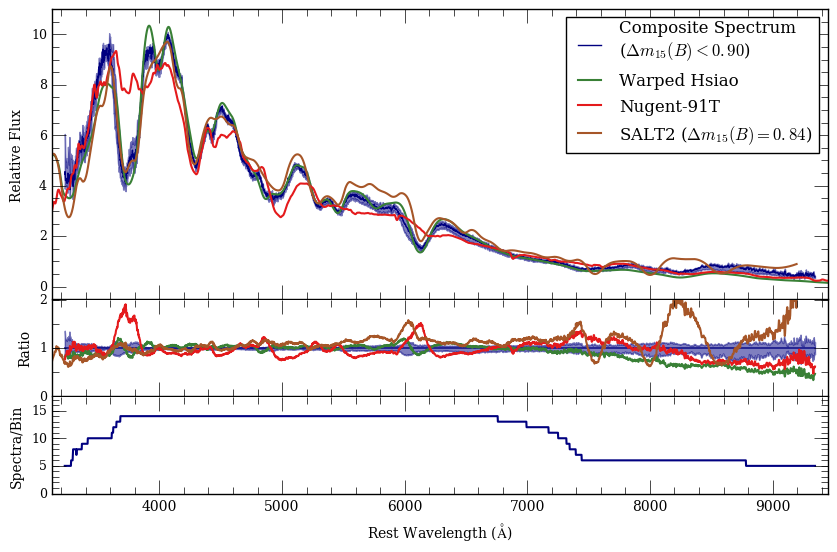

In [48]:
comps_and_temps = []
for comp in composites_p1:
    comps_and_temps.append(comp)
    
srange = np.where((p1_salt_template.wavelength > 2000.) & (p1_salt_template.wavelength < 9200))[0]
p1_salt_template.x1 = srange[0]
p1_salt_template.x2 = srange[-1]

comps_and_temps.append(h_template)
comps_and_temps.append(nug91t_template)
comps_and_temps.append(p1_salt_template)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[0], True)

comps_and_temps[0].name = "Comp"
comps_and_temps[1].name = "Hsiao"
comps_and_temps[2].name = "Nugent"
comps_and_temps[3].name = "SALT2"
for comp in comps_and_temps:
    v_strong, si_min_wave = sa.measure_velocity(comp.wavelength[comp.x1:comp.x2],comp.flux[comp.x1:comp.x2], 5900., 6300.)
    print comp.name, 'v = ', v_strong
print np.average(comps_and_temps[0].dm15_array[comps_and_temps[0].x1:comps_and_temps[0].x2])
query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1], comps_and_temps[2], comps_and_temps[3]], include_spec_bin=True, 
                     legend_labels = ["Composite Spectrum \n($\Delta m_{15} (B) < 0.90$)", "Warped Hsiao", "Nugent-91T", "SALT2 ($\Delta m_{15} (B) = 0.84$)"],
#                      rm_last_label=True,
                     savename = 'template_comparisons_updated/temp_max_light_lowdm15')

In [38]:
comp = composites_m2[0]

true_Bflux = B.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Bmag = -2.5 * np.log10(true_Bflux) - B.Vega_zero_mag

true_Vflux = V.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Vmag = -2.5 * np.log10(true_Vflux) - V.Vega_zero_mag

true_Rflux = R.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Rmag = -2.5 * np.log10(true_Rflux) - R.Vega_zero_mag

In [39]:
true_BmV = true_Bmag - true_Vmag
true_VmR = true_Vmag - true_Rmag

In [40]:
best_knots = opt.minimize(color_residuals, spline_knot_vals, args = (true_BmV, true_VmR, hsiao_max), method = 'Nelder-Mead').x
print best_knots

[ 1.00000001  1.          1.        ]
-0.079515943888 0.00687264266107
[ 1.05000001  1.          1.        ]
-0.135497477458 0.00966655441418
[ 1.00000001  1.05        1.        ]
-0.0221791626868 -0.0479932773108
[ 1.00000001  1.          1.05      ]
-0.0802701495813 0.0585216073775
[ 0.95000001  1.03333333  1.03333333]
0.017914059335 0.00232544400635
[ 0.90000001  1.05        1.05      ]
0.100069934719 -0.00121737273614
[ 0.93333334  1.06666667  1.06666667]
0.0757990974852 -0.000197307433041
[ 0.8888889   1.11111111  1.02777778]
0.184869735278 -0.0893643962993
[ 0.81481482  1.10185185  1.0962963 ]
0.276540957787 -0.0135109358921
[ 0.72222223  1.12777778  1.14444444]
0.45148098999 0.00232127983222
[ 0.80246914  1.10864198  1.04938272]
0.305078860016 -0.069093082001
[ 0.90061729  1.07716049  1.06234568]
0.129902463597 -0.0173783724936
[ 0.85473252  1.04156379  1.11131687]
0.149154367861 0.0664376228892
[ 0.83765433  1.00679012  1.15308642]
0.130248697815 0.142493425027
[ 0.81344308  1.

In [41]:
best_spline = inter.splrep(spline_knot_locs, best_knots, k=2)
best_spline_func = inter.splev(hsiao_max[0], best_spline, ext = 0)

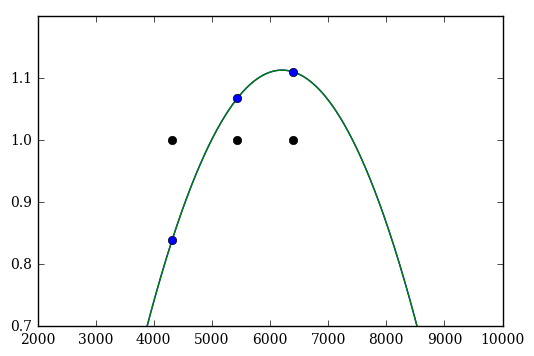

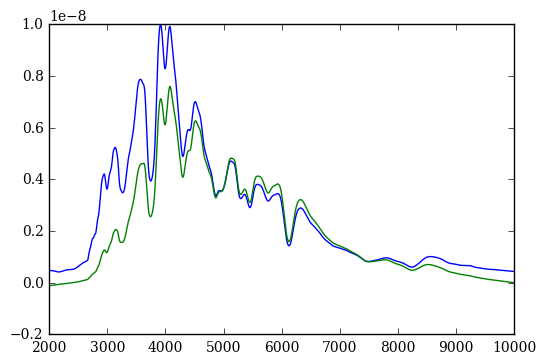

In [42]:
warped_hsiao = best_spline_func*hsiao_max[1]
plt.plot(hsiao_max[0], warped_hsiao/hsiao_max[1])
plt.plot(hsiao_max[0], best_spline_func)
plt.plot(spline_knot_locs, spline_knot_vals, 'ko')
plt.plot(spline_knot_locs, best_knots, 'bo')
plt.xlim([2000,10000])
plt.ylim([.7,1.2])
plt.show()
plt.plot(hsiao_max[0], hsiao_max[1])
plt.plot(hsiao_max[0], warped_hsiao)
plt.xlim([2000,10000])
plt.show()

In [43]:
wave_h = hsiao_max[0]
flux_h = warped_hsiao
wave_interp_h = np.arange(1000., 12000., dtype=int, step=2)
flux_spl_h = inter.splrep(wave_h, flux_h)
flux_interp_h = inter.splev(wave_interp_h, flux_spl_h, ext = 3)
h_template_2 = composite.supernova(wave_interp_h, flux_interp_h)
h_template_2.phase_array = np.zeros(len(flux_interp_h))

Comp v =  11290.7621201
Hsiao v =  10997.3983334
SALT2 v =  12466.8773158


query_db.py:663: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  def normalize_comp(comp):
query_db.py:664: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  norm = 1./np.amax(comp.flux[comp.x1:comp.x2])


[-5.0, 0.0, 5.0, 10.0, '', 20.0]


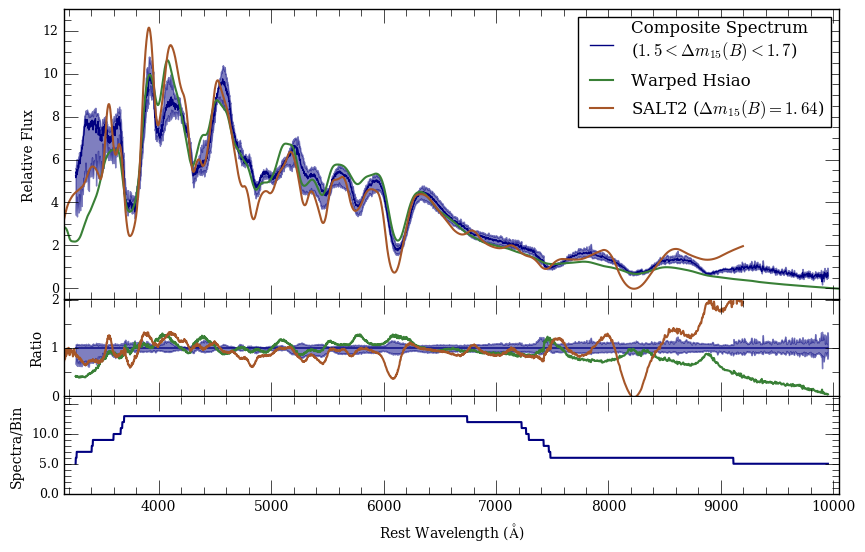

In [51]:
comps_and_temps = []
for comp in composites_m2:
    comps_and_temps.append(comp)
    
srange = np.where((m2_salt_template.wavelength > 2000.) & (m2_salt_template.wavelength < 9200))[0]
m2_salt_template.x1 = srange[0]
m2_salt_template.x2 = srange[-1]

comps_and_temps.append(h_template_2)
comps_and_temps.append(m2_salt_template)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[0], True)

comps_and_temps[0].name = "Comp"
comps_and_temps[1].name = "Hsiao"
comps_and_temps[2].name = "SALT2"
for comp in comps_and_temps:
    v_strong, si_min_wave = sa.measure_velocity(comp.wavelength[comp.x1:comp.x2],comp.flux[comp.x1:comp.x2], 5900., 6300.)
    print comp.name, 'v = ', v_strong
query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1], comps_and_temps[2]], include_spec_bin=True, legend_labels = ["Composite Spectrum \n($ 1.5 < \Delta m_{15} (B) < 1.7$)", "Warped Hsiao", "SALT2 ($\Delta m_{15} (B) = 1.64$)"],
                     rm_last_label=True,
                     savename = 'template_comparisons_updated/temp_max_light_middm15')